In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt


In [15]:
# Load Data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape (28x28 images to 784 length vectors
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# channel dimension
x_train_conv = np.expand_dims(x_train, axis=1)
x_test_conv = np.expand_dims(x_test, axis=1)

print(f"Flattened shape: {x_train_flat.shape}")
print(f"Convolutional train shape: {x_train_conv.shape}")



Flattened shape: (60000, 784)
Convolutional train shape: (60000, 1, 28, 28)


In [16]:
# Fully-connected autoencoder

# Input size for MINST images
input_size = 784

# Desired size of the encoded representation
encoding_dim = 32

# Encoder
input_img = Input(shape=(input_size,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoder_output = Dense(encoding_dim, activation='relu')(encoded)

# Decoder
decoded = Dense(64, activation='relu')(encoder_output)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(input_size, activation='sigmoid')(decoded)

# Autoencoder model
autoencoder = Model(input_img, decoded)

# Compile autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Create seperate encoder model...extract latent representation
encoder = Model(input_img, encoder_output)

print("Simple fully-connected autoencoder architecture")
autoencoder.summary()



                

Simple fully-connected autoencoder architecture


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,384 (868.69 KB)

 Trainable params: 222,384 (868.69 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# train fully-connected autoencoder

autoencoder.fit(x_train_flat, x_train_flat,
                epochs=5,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_flat, x_test_flat))

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3425 - val_loss: 0.1655
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1564 - val_loss: 0.1371
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1346 - val_loss: 0.1249
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1247 - val_loss: 0.1187
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1192 - val_loss: 0.1142


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step

Shape of encoded images (latent space): (10000, 32)
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step


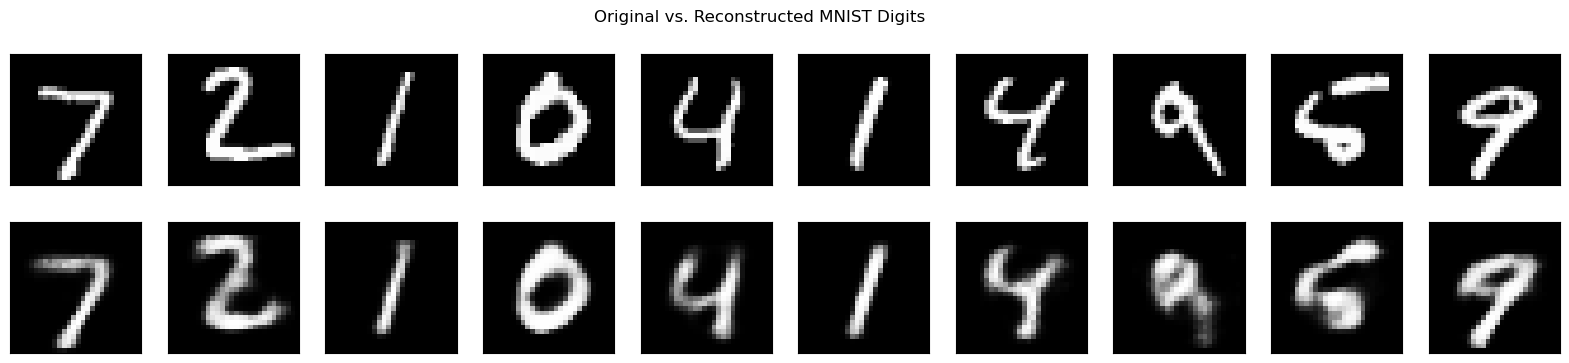

In [18]:
# Get encoded (latent) representations from the test set
encoded_imgs = encoder.predict(x_test_flat) # For flattened autoencoder
# encoded_imgs_conv = encoder_conv.predict(x_test_conv) # For convolutional autoencoder

print(f"\nShape of encoded images (latent space): {encoded_imgs.shape}")

# You can also get reconstructed images to visualize how well it learned
decoded_imgs = autoencoder.predict(x_test_flat)

# Visualize original vs. reconstructed images
n = 10 # Number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28)) # Use original x_test for display
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.suptitle("Original vs. Reconstructed MNIST Digits")
plt.show()


In [19]:
# Return given digit utilizing MNIST 'handwriting'

# --- Modified Helper Function to Get a Single Reconstructed Digit Image ---
def get_reconstructed_mnist_digit_image(
    digit_to_recreate, autoencoder_model, x_test_flat, test_labels_array
):
    """
    Returns a 28x28 reconstructed image array of a specified MNIST digit.

    Args:
        digit_to_recreate (int): The digit (0-9) to recreate.
        autoencoder_model (tf.keras.Model): The trained fully connected autoencoder model.
        x_test_flat (np.array): The preprocessed (flattened and normalized) MNIST test data.
        test_labels_array (np.array): The labels for the MNIST test data.

    Returns:
        np.array: A 28x28 numpy array representing the reconstructed digit image,
                  or None if the digit is out of range or not found.
    """
    if not 0 <= digit_to_recreate <= 9:
        print(f"Warning: Digit '{digit_to_recreate}' is not a valid MNIST digit (0-9). Skipping.")
        return None

    # Find indices of the desired digit in the test set
    indices = np.where(test_labels_array == digit_to_recreate)[0]

    if len(indices) == 0:
        print(f"Warning: No examples of digit {digit_to_recreate} found in the test set. Skipping.")
        return None

    # Take the first example of that digit for reconstruction
    original_image_flat = x_test_flat[indices[0]:indices[0]+1] # Keep batch dimension

    # Predict the reconstructed image
    reconstructed_image_flat = autoencoder_model.predict(original_image_flat, verbose=0)

    # Reshape to 28x28 for consistent output
    reconstructed_image_reshaped = reconstructed_image_flat.reshape(28, 28)

    return reconstructed_image_reshaped

# --- New Function to Recreate Multi-Digit Numbers ---
def recreate_multi_digit_number(number, autoencoder_model, x_test_flat, y_test):
    """
    Recreates a multi-digit number by combining reconstructed MNIST digits.

    Args:
        number (int or str): The number to recreate (e.g., 100, "543").
        autoencoder_model (tf.keras.Model): The trained fully connected autoencoder model.
        x_test_flat (np.array): The preprocessed (flattened and normalized) MNIST test data.
        y_test (np.array): The labels for the MNIST test data.
    """
    number_str = str(number)
    digit_images = []

    print(f"Attempting to recreate number: {number_str}")

    for char_digit in number_str:
        try:
            digit = int(char_digit)
            reconstructed_img = get_reconstructed_mnist_digit_image(
                digit, autoencoder_model, x_test_flat, y_test
            )
            if reconstructed_img is not None:
                digit_images.append(reconstructed_img)
            else:
                print(f"Could not reconstruct digit '{char_digit}'. Result will be incomplete.")
        except ValueError:
            print(f"Warning: '{char_digit}' is not a valid digit. Skipping.")
            continue

    if not digit_images:
        print("Could not recreate any digits for the given number.")
        return

    # Horizontally stack the reconstructed digit images
    combined_image = np.hstack(digit_images)

    plt.figure(figsize=(len(digit_images) * 2, 3)) # Adjust figure size based on number of digits
    plt.imshow(combined_image, cmap='gray')
    plt.title(f"Reconstructed Number: {number_str}")
    plt.axis('off')
    plt.show()


Attempting to recreate number: 100000


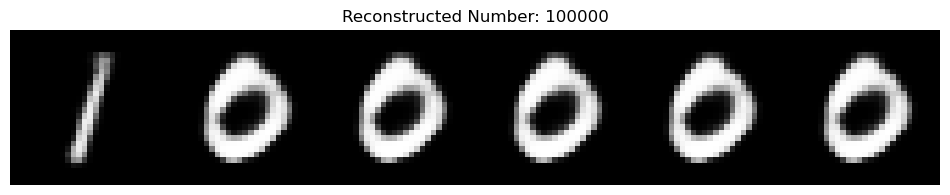

In [24]:
recreate_multi_digit_number(100000, autoencoder, x_test_flat, y_test)